# Analyzing Results of `math_dataset` experiments

## Set up

In [1]:
import wandb
import pandas as pd
import plotly.express as px
import sys; sys.path.append('../..')
import utils
import models
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2023-08-28 17:07:16.511569: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-28 17:07:16.513593: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-28 17:07:16.554670: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-28 17:07:16.555641: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-28 17:07:17.402339: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
from transformer_modules import TeacherForcingAccuracy
from multi_head_attention import MultiHeadAttention

custom_objects = dict(TeacherForcingAccuracy=TeacherForcingAccuracy, MultiHeadAttention=MultiHeadAttention)

In [3]:
# region
# global max lengths of questions and answers
max_q_length, max_a_length = 160, 30

start_char = '@'
eos_char = ';'

vocab = np.loadtxt('text_vectorizer_vocabs/global/vocabulary.txt', dtype=str)

q_text_vectorizer = tf.keras.layers.TextVectorization(
    standardize=None,
    split='character',
    output_mode='int',
    output_sequence_length=max_q_length,
    # vocabulary='text_vectorizer_vocabs/global/vocabulary.txt'
    # vocabulary='text_vectorizer_vocabs/global/vocabulary.txt'
)

a_text_vectorizer = tf.keras.layers.TextVectorization(
    standardize=None,
    split='character',
    output_mode='int',
    output_sequence_length=max_a_length+2,
    # vocabulary='text_vectorizer_vocabs/global/vocabulary.txt'
)

q_text_vectorizer.load_assets('text_vectorizer_vocabs/global')
a_text_vectorizer.load_assets('text_vectorizer_vocabs/global')

# endregion

2023-08-28 17:07:18.792888: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [4]:
def load_dataset(task, train_size, batch_size,
    q_text_vectorizer=q_text_vectorizer, a_text_vectorizer=a_text_vectorizer,
    max_q_length=max_q_length, max_a_length=max_a_length):

    train_examples, val_examples = tfds.load(
        f'math_dataset/{task}',
        split=['train', 'test'],
        as_supervised=True)

    source_len = max_q_length
    target_len = max_a_length + 1 # max length + 2 (for start token and end token) - 1 ([:-1])
    label_len = max_a_length + 1 # max length + 2 (for start token and end token) - 1 ([1:])

    def prepend_start_token(q,a):
        source = q
        a = start_char + a + eos_char
        return q, a

    def vectorize_qa(q,a):
        return q_text_vectorizer(q), a_text_vectorizer(a)

    def get_source_target_label(q,a):
        source = q
        target = a[:-1]
        label = a[1:]
        source = tf.ensure_shape(source, (source_len,))
        target = tf.ensure_shape(target, (target_len,))
        label = tf.ensure_shape(label, (label_len,))

        return (source, target), label

    train_examples = train_examples.map(prepend_start_token).map(vectorize_qa).map(get_source_target_label)
    val_examples = val_examples.map(prepend_start_token).map(vectorize_qa).map(get_source_target_label)

    buffer_size = 16_000
    train_ds = train_examples.shuffle(buffer_size).take(train_size).cache().batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_examples.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return train_ds, val_ds

In [5]:
def invert_seq_vector(sequence, vectorizer):
    vocab = np.array(vectorizer.get_vocabulary())
    seq = list(vocab[sequence])
    seq = ''.join(seq)
    return seq

def autoregressive_predict(model, source, target):
    n, seqs_length = np.shape(target)

    output = np.zeros(shape=(n, (seqs_length+1)), dtype=int)
    output[:,0] = a_text_vectorizer.get_vocabulary().index(start_char)

    for i in range(seqs_length):
        predictions = model((source, output[:, :-1]), training=False)
        predictions = predictions[:, i, :]
        predicted_id = np.argmax(predictions, axis=-1)
        output[:,i+1] = predicted_id

    return output[:, 1:]

In [6]:
def fetch_model(artifact_path, artifact_root_dir='model_artifacts'):
    api = wandb.Api()
    artifact = api.artifact(artifact_path, type='model')
    artifact_dir = artifact.download(f"{artifact_root_dir}/{artifact_path.replace('/','-')}")
    model = tf.keras.models.load_model(artifact_dir, custom_objects=custom_objects)
    return model

def recompile_model(model, a_text_vectorizer):
    ignore_class = a_text_vectorizer.get_vocabulary().index('')
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, ignore_class=None)
    teacher_forcing_accuracy = TeacherForcingAccuracy(ignore_class=ignore_class)
    model.compile(loss=loss, optimizer='adam', metrics=teacher_forcing_accuracy)
    return model

def eval_model(artifact_path, val_ds, artifact_root_dir='model_artifacts', q_text_vectorizer=q_text_vectorizer, a_text_vectorizer=a_text_vectorizer):
    model = fetch_model(artifact_path, artifact_root_dir)
    model = recompile_model(model, a_text_vectorizer)

    print('evaluation on val_ds')
    print(model.evaluate(val_ds, return_dict=True))

    (source, target), label = next(iter(val_ds.take(1)))
    source, target, label = np.array(source), np.array(target), np.array(label)

    print()
    print(f'evaluating full-sequence accuracy on a single batch of size {len(source)}')
    preds = autoregressive_predict(model, source, target)
    full_seq_acc = np.mean(np.all(preds == label, axis=1))
    print(f'full_seq_acc: {full_seq_acc}')

    print('acc by position')
    acc_by_pos = np.mean(preds == label, axis=0)
    plt.plot(acc_by_pos)

    print()
    print('sample of predictions:')
    samples = np.random.choice(len(source), size=5, replace=False)
    for s, t, p, l in zip(source[samples], target[samples], preds[samples], label[samples]):
        print()
        print(f'Q: {invert_seq_vector(s, q_text_vectorizer)}')
        print(f'A: {invert_seq_vector(l, a_text_vectorizer)}')
        print(f'P: {invert_seq_vector(p, a_text_vectorizer)}')

## `polynomials__expand`

In [7]:
# region
task = 'polynomials__expand'
train_ds, val_ds = load_dataset(task, train_size=-1, batch_size=512)
# endregion

### Transformer - Medium

wandb:   5 of 5 files downloaded.  


evaluation on val_ds
20/20 [==============================] - 8s 387ms/step - loss: 0.2562 - teacher_forcing_accuracy: 0.7593
{'loss': 0.25621023774147034, 'teacher_forcing_accuracy': 0.75929194688797}

evaluating full-sequence accuracy on a single batch of size 512
full_seq_acc: 0.015625
acc by position

sample of predictions:

Q: Expand (0*j + 0*j + j + 3 + 3 + j - 3 - 2*j - j + 2*j + j - j + j + (0 + 2*j + 0)*(1 - 2 + 0) + 0*j + 3*j - 4*j)*(2*j - j + j)*(4*j - 30 + 30)*(5*j - 3*j - j).
A: -8*j**4 + 24*j**3;
P: -120*j**4 + 100*j**3;

Q: Expand (1429 - 1429 + 31*c)*(c**4 + 2*c**2 - 2*c**2) - 7*c**3 - 6 + 7*c**3 - c**5.
A: 30*c**5 - 6;
P: 13*c**5 - 7;

Q: Expand (-3529 - 5406 - 1957 + 1667)*(-d - 4*d + 3*d).
A: 18450*d;
P: 10776*d;

Q: Expand 2*b**5 + 5*b**3 - 5*b**3 + (2*b - 6*b + 3*b)*(5*b**2 - 2*b**4 - 5*b**2) + 125*b**5 + 129*b**5 - 279*b**5 + 4*b**5 - 4*b**5 - b**5.
A: -22*b**5;
P: -2*b**5;

Q: Expand (35*q**2 + 17 - 6*q**2 - 73*q**2)*(0*q - q - q).
A: 88*q**3 - 34*q;
P: 10*q**3 -

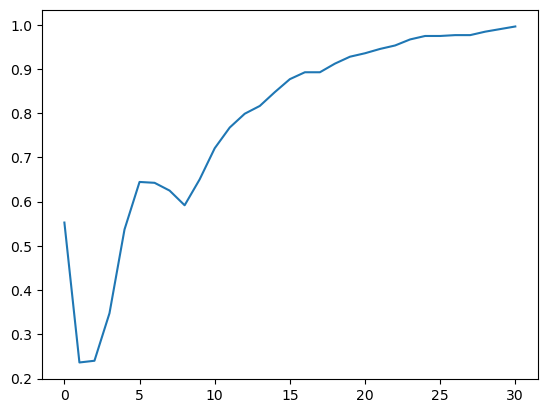

In [8]:
eval_model('awni00/math-polynomials__expand/model-silver-wood-5:latest', val_ds)

### Relational Abstractor - Medium

wandb:   5 of 5 files downloaded.  


evaluation on val_ds
20/20 [==============================] - 19s 897ms/step - loss: 0.1939 - teacher_forcing_accuracy: 0.8066
{'loss': 0.1939081847667694, 'teacher_forcing_accuracy': 0.8066248893737793}

evaluating full-sequence accuracy on a single batch of size 512
full_seq_acc: 0.046875
acc by position

sample of predictions:

Q: Expand (-3529 - 5406 - 1957 + 1667)*(-d - 4*d + 3*d).
A: 18450*d;
P: 16000*d;

Q: Expand (-22*n**2 + 11*n**2 - 24*n**2 + (2*n + 1 - 1)*(18*n - 205 + 205) + n**2 + 2*n - 2*n)*(-2*n**2 + 2*n**2 + 2*n**2).
A: 4*n**4;
P: -100*n**4;

Q: Expand b - 1 + 1 + (-2*b - 2*b - b)*(9 - 13 - 19) + (3 - 4 - 1)*(4*b + 0*b + 9*b).
A: 90*b;
P: 107*b;

Q: Expand (-5 + 3*r + 5)*(0 - 2 + 1) + 20 - 50 + 30 - 457*r.
A: -460*r;
P: -458*r;

Q: Expand (-j**3 - 3*j**3 + 3*j**3)*(-j - 3 + 3)*(21109 - 21109 - 2391*j).
A: -2391*j**5;
P: -2391*j**5;


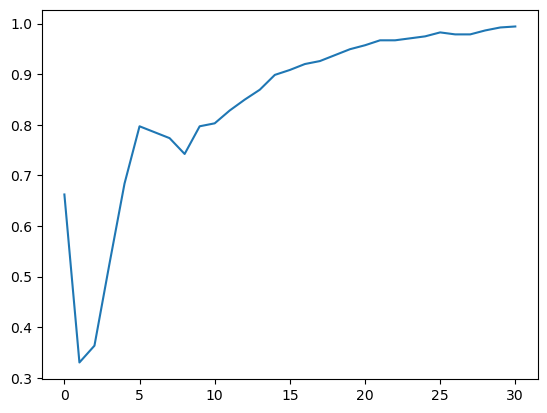

In [9]:
eval_model('awni00/math-polynomials__expand/model-fearless-galaxy-4:latest', val_ds)

### Relational Abstractor2 - Medium

wandb:   5 of 5 files downloaded.  


evaluation on val_ds
20/20 [==============================] - 16s 790ms/step - loss: 0.2277 - teacher_forcing_accuracy: 0.7810
{'loss': 0.22766496241092682, 'teacher_forcing_accuracy': 0.7810371518135071}

evaluating full-sequence accuracy on a single batch of size 512
full_seq_acc: 0.029296875
acc by position

sample of predictions:

Q: Expand (-j**3 - 3*j**3 + 3*j**3)*(-j - 3 + 3)*(21109 - 21109 - 2391*j).
A: -2391*j**5;
P: -2391*j**5;

Q: Expand (-p**4 - p**4 + p**4)*(-59 - 89 - 80 - 190 - 11*p).
A: 11*p**5 + 418*p**4;
P: 22*p**5 + 117*p**4;

Q: Expand (227*h - 18*h - 206*h - 484)*(-2 + 0 + 3).
A: 3*h - 484;
P: -h - 484;

Q: Expand (-3*a**3 - a**3 + 5*a**3)*(26*a + 32*a - 92*a - 16)*(-3 + 2 + 4).
A: -102*a**4 - 48*a**3;
P: -12*a**4 - 168*a**3;

Q: Expand (-1 - 1 + 0)*(-4*c + 0*c + 3*c) - 70*c - 90*c - 7 + 172*c.
A: 14*c - 7;
P: -10*c - 7;


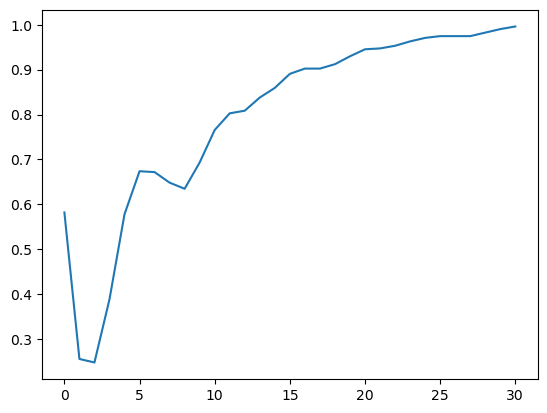

In [10]:
eval_model('awni00/math-polynomials__expand/model-glamorous-galaxy-3:latest', val_ds)

## polynomials__add

In [11]:
train_ds, val_ds = load_dataset('polynomials__add', train_size=-1, batch_size=512)

### Transformer - Medium

wandb:   5 of 5 files downloaded.  


evaluation on val_ds
20/20 [==============================] - 8s 380ms/step - loss: 17.6658 - teacher_forcing_accuracy: 0.8345
{'loss': 17.665842056274414, 'teacher_forcing_accuracy': 0.8345461487770081}

evaluating full-sequence accuracy on a single batch of size 512
full_seq_acc: 0.0
acc by position

sample of predictions:

Q: Let o(u) = 5. Let z(h) = -4*h - 1. Let v(b) = -5*b. Let g(p) = -3*v(p) + 4*z(p). Let k = 17 + -22. Calculate k*g(q) - 4*o(q).
A: 5*q;
P: q + 2;;;;;;;;;;;;;;;;;;;;;;;;;;

Q: Suppose -5*s + 8 = 28. Let v(p) = 3*p - 4. Let x(o) = 10*o + 13. Let w(l) = 6*l + 10. Let u(a) = -3*w(a) + 2*x(a). What is s*v(q) + 5*u(q)?
A: -2*q - 4;
P: q + 2;;;;;;;;;;;;;;;;;;;;;;;;;;

Q: Let j be (5/(-2) - -1)/(3/(-4)). Suppose b = 6 + j. Let y(k) = 9*k - 5. Let f(z) = 6*z - 3. Give b*f(u) - 5*y(u).
A: 3*u + 1;
P: 3*u;;;;;;;;;;;;;;;;;;;;;;;;;;;;

Q: Let c(g) = 13*g**3 + 3*g**2 + 13*g. Let b = 145 + -147. Let j(o) = 4*o**3 + o**2 + 4*o. Determine b*c(d) + 7*j(d).
A: 2*d**3 + d**2 + 2*d;


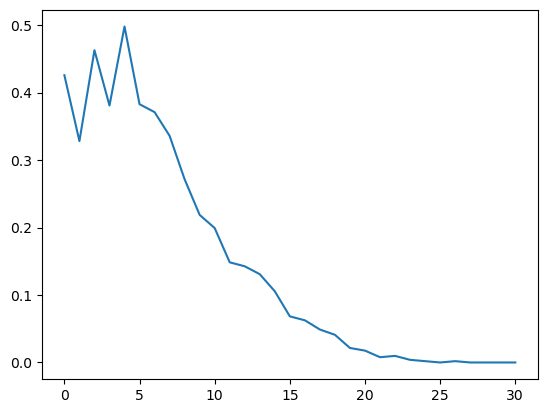

In [12]:
eval_model('awni00/math-polynomials__add/model-lemon-frost-4:latest', val_ds, q_text_vectorizer=q_text_vectorizer, a_text_vectorizer=a_text_vectorizer)

### Relational Abstractor - Medium

wandb:   5 of 5 files downloaded.  


evaluation on val_ds
20/20 [==============================] - 19s 892ms/step - loss: 15.2195 - teacher_forcing_accuracy: 0.8594
{'loss': 15.219465255737305, 'teacher_forcing_accuracy': 0.8594107031822205}

evaluating full-sequence accuracy on a single batch of size 512
full_seq_acc: 0.0
acc by position

sample of predictions:

Q: Let a(p) be the second derivative of p**3/6 - 4*p. Let m(v) = -20*v + 5. Let d(l) = -28*l + 6. Let c(o) = 3*d(o) - 4*m(o). Determine 8*a(y) + c(y).
A: 4*y - 2;
P: -2*y + 2;;;;;;;;;;;;;;;;;;;;;;;

Q: Let q(w) = -w + 2. Let d(f) = -72*f + 216. Let s be d(3). Let b(z) = -z**2 + 9*z - 9. Let i be b(7). Let a(u) = -4 + s + i. Give -3*a(k) + 2*q(k).
A: -2*k + 1;
P: -k + 2;2;2;;;;;;;;;;;;;;;;;;;;;

Q: Let z(c) = -c**3 + c**2 - c + 1. Let i(o) = 8*o**3 - 4*o**2 + 4*o - 4. Let x be 6/((90/135)/(1/(-3))). Determine x*i(t) - 12*z(t).
A: -12*t**3;
P: -4*t**3;+ 4*t**2;; 4*t + 4;;;;;

Q: Let b(h) = 76*h**2 + 4*h + 5. Let c(r) = 156*r**2 + 10*r + 9. Calculate 5*b(a) - 2*c(a)

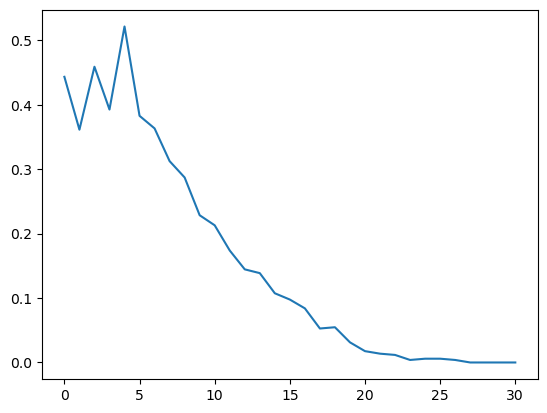

In [13]:
eval_model('awni00/math-polynomials__add/model-logical-wave-5:latest', val_ds)

### Relational Abstractor2 - Medium

wandb:   5 of 5 files downloaded.  


evaluation on val_ds
20/20 [==============================] - 17s 794ms/step - loss: 15.1832 - teacher_forcing_accuracy: 0.8592
{'loss': 15.183246612548828, 'teacher_forcing_accuracy': 0.8592194318771362}

evaluating full-sequence accuracy on a single batch of size 512
full_seq_acc: 0.0
acc by position

sample of predictions:

Q: Let h(y) = -45*y**3 - 27*y**2 + 27*y. Let z(v) = v**3 + v**2 - v. Let t(j) = 31*j + 1487. Let n be t(-48). What is n*h(l) - 27*z(l)?
A: 18*l**3;
P: -3*l**3; + 9*l;;;;;;;;;;;;;;;;;

Q: Let q(w) = -2 + 1 - 2*w - 3. Let j(i) = -i - 2. Let k be -465*(3 + 50/(-15)). Let a = k - 158. Give a*q(m) + 7*j(m).
A: -m - 2;
P: -m + 1;;;;;;;;;;;;;;;;;;;;;;;;;

Q: Let k(d) = 4*d - 10. Let f(y) = -9*y + 24. Let l(m) = 3*f(m) + 7*k(m). Suppose -64 = u + 2*u - s, 5*s + 16 = -u. Let j(t) = -4*t - 7. Give u*l(n) - 6*j(n).
A: 3*n;
P: -2*n + 1;;;;;;;;;;;;;;;;;;;;;;;

Q: Let k(j) = -38*j**2 + 78*j + 4. Let w(y) = -6*y**2. Calculate k(t) - 6*w(t).
A: -2*t**2 + 78*t + 4;
P: 2*t**2 + 78

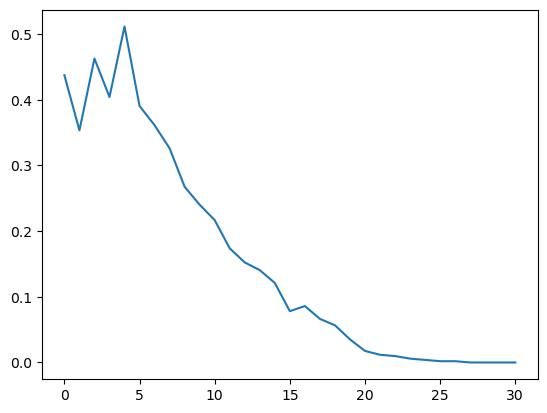

In [14]:
eval_model('awni00/math-polynomials__add/model-curious-dragon-3:latest', val_ds)

## `polynomials__collect`

In [15]:
# region
task = 'polynomials__collect'

vocab = np.loadtxt('text_vectorizer_vocabs/global_old/vocabulary.txt', dtype=str)

q_text_vectorizer_ = tf.keras.layers.TextVectorization(
    standardize=None,
    split='character',
    output_mode='int',
    output_sequence_length=max_q_length,
    vocabulary=vocab
)

a_text_vectorizer_ = tf.keras.layers.TextVectorization(
    standardize=None,
    split='character',
    output_mode='int',
    output_sequence_length=max_a_length+2,
    vocabulary=vocab
)

train_ds, val_ds = load_dataset(task, train_size=-1, batch_size=512, q_text_vectorizer=q_text_vectorizer_, a_text_vectorizer=a_text_vectorizer_)
# endregion

### Transformer - Medium

wandb:   5 of 5 files downloaded.  


evaluation on val_ds
20/20 [==============================] - 8s 392ms/step - loss: 20.1716 - teacher_forcing_accuracy: 0.8932
{'loss': 20.171602249145508, 'teacher_forcing_accuracy': 0.8932151198387146}

evaluating full-sequence accuracy on a single batch of size 512
full_seq_acc: 0.0
acc by position

sample of predictions:

Q: Collect[UNK]the[UNK]terms[UNK]in[UNK]-27*r**3[UNK]+[UNK]5301*r**2[UNK]-[UNK]5307*r**2[UNK]-[UNK]44*r[UNK]+[UNK]44*r.
A: -27*r**3[UNK]-[UNK]6*r**2;
P: *3;;;**3;[UNK]+[UNK]43*r;+[UNK]-[UNK]4*r;-[UNK]4;;;

Q: Collect[UNK]the[UNK]terms[UNK]in[UNK]133*y**3[UNK]+[UNK]y[UNK]-[UNK]37*y**3[UNK]-[UNK]36*y**3[UNK]+[UNK]10*y**3[UNK]-[UNK]18*y**3[UNK]-[UNK]27*y**3.
A: 25*y**3[UNK]+[UNK]y;
P: *3[UNK]+[UNK]y;**2[UNK]+[UNK]y;;;;-[UNK]13*y;-[UNK]2;-[UNK]

Q: Collect[UNK]the[UNK]terms[UNK]in[UNK]28[UNK]-[UNK]2*u**3[UNK]-[UNK]1402*u**2[UNK]-[UNK]66[UNK]+[UNK]1402*u**2[UNK]+[UNK]38.
A: -2*u**3;
P: *3;;;;**3[UNK]-[UNK]1;;;;[UNK]+[UNK]2;;;;;;;;;;

Q: Collect[UNK]the[UNK]terms[UNK]in

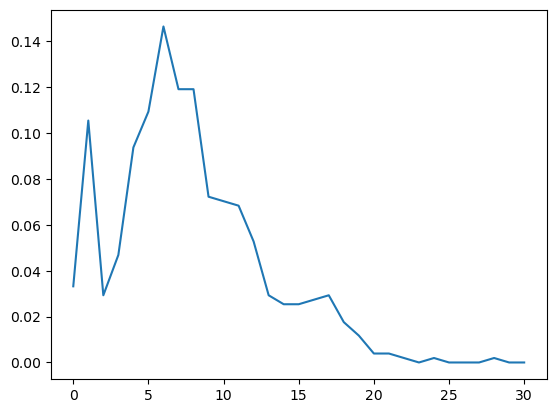

In [16]:
eval_model('awni00/math-polynomials__collect/model-usual-river-1:latest', val_ds, q_text_vectorizer=q_text_vectorizer_, a_text_vectorizer=a_text_vectorizer_)

### Relational Abstractor - Medium

wandb:   5 of 5 files downloaded.  


evaluation on val_ds
20/20 [==============================] - 19s 902ms/step - loss: 17.9783 - teacher_forcing_accuracy: 0.9500
{'loss': 17.97834014892578, 'teacher_forcing_accuracy': 0.9500062465667725}

evaluating full-sequence accuracy on a single batch of size 512
full_seq_acc: 0.0
acc by position

sample of predictions:

Q: Collect[UNK]the[UNK]terms[UNK]in[UNK]322[UNK]-[UNK]322[UNK]+[UNK]18780*z**3.
A: 18780*z**3;
P: 8880*z**3;;;0;;;;;;;;;;;;0;;;;;

Q: Collect[UNK]the[UNK]terms[UNK]in[UNK]59*x[UNK]-[UNK]13[UNK]+[UNK]4[UNK]-[UNK]66*x[UNK]+[UNK]9[UNK]-[UNK]130*x.
A: -137*x;
P: *[UNK]-1[UNK]137*x;-[UNK]10;;;;;;;;;;;;;;;;

Q: Collect[UNK]the[UNK]terms[UNK]in[UNK]30948*s[UNK]-[UNK]116172*s[UNK]-[UNK]118605*s[UNK]-[UNK]37191*s[UNK]-[UNK]3*s**2.
A: -3*s**2[UNK]-[UNK]241020*s;
P: *[UNK]-[UNK]2[UNK]277616*s;;;;;;;;;;;;*[UNK]2;0

Q: Collect[UNK]the[UNK]terms[UNK]in[UNK]867*l[UNK]+[UNK]797*l[UNK]+[UNK]864*l[UNK]-[UNK]3422*l[UNK]+[UNK]871*l.
A: -23*l;
P: 7*l;;;;;;;;;;;;;;;;;;**2;[UNK]+[UNK]6*

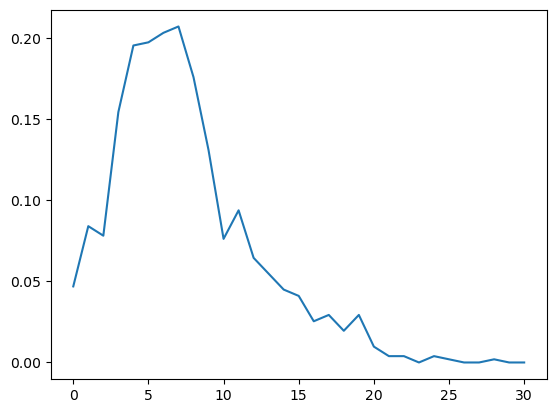

In [17]:
eval_model('awni00/math-polynomials__collect/model-firm-smoke-2:latest', val_ds, q_text_vectorizer=q_text_vectorizer_, a_text_vectorizer=a_text_vectorizer_)

## polynomials__evaluate

In [18]:
# region
task = 'polynomials__evaluate'

vocab = np.loadtxt('text_vectorizer_vocabs/global_old/vocabulary.txt', dtype=str)

q_text_vectorizer_ = tf.keras.layers.TextVectorization(
    standardize=None,
    split='character',
    output_mode='int',
    output_sequence_length=max_q_length,
    vocabulary=vocab
)

a_text_vectorizer_ = tf.keras.layers.TextVectorization(
    standardize=None,
    split='character',
    output_mode='int',
    output_sequence_length=max_a_length+2,
    vocabulary=vocab
)

train_ds, val_ds = load_dataset(task, train_size=-1, batch_size=512, q_text_vectorizer=q_text_vectorizer_, a_text_vectorizer=a_text_vectorizer_)
# endregion

### Transformer - Medium

wandb:   5 of 5 files downloaded.  


evaluation on val_ds
20/20 [==============================] - 8s 381ms/step - loss: 24.0066 - teacher_forcing_accuracy: 0.5951
{'loss': 24.006643295288086, 'teacher_forcing_accuracy': 0.5950583219528198}

evaluating full-sequence accuracy on a single batch of size 512
full_seq_acc: 0.0
acc by position

sample of predictions:

Q: Let[UNK]d(g)[UNK]=[UNK]-7*g**3[UNK]-[UNK]119*g**2[UNK]+[UNK]89*g[UNK]+[UNK]1481.[UNK]What[UNK]is[UNK]d(-17)?
A: -32;
P: ;;;;;6;;;;6;6;2;6;6;6;6;;;;6;6;

Q: Let[UNK]b(o)[UNK]=[UNK]5*o**2[UNK]+[UNK]66*o[UNK]-[UNK]7107.[UNK]Determine[UNK]b(-45).
A: 48;
P: 8;88;2;;8;;;;8;8;8;8;2;8;8;2;2;

Q: Let[UNK]i(z)[UNK]=[UNK]z**3[UNK]+[UNK]20*z**2[UNK]+[UNK]700*z[UNK]+[UNK]3702.[UNK]What[UNK]is[UNK]i(-6)?
A: 6;
P: ;;;;;;2;;;;;;2;2;;;;2;2;;;;2;2;

Q: Let[UNK]g(m)[UNK]=[UNK]-m**3[UNK]+[UNK]8*m**2[UNK]+[UNK]59*m[UNK]-[UNK]527.[UNK]Determine[UNK]g(11).
A: -241;
P: ;5;;;;;;;;1;;;7;1;;7;7;1;;;7;3;

Q: Let[UNK]a(x)[UNK]=[UNK]x**2[UNK]+[UNK]83*x[UNK]-[UNK]659.[UNK]What[UNK]is[UNK]a(-

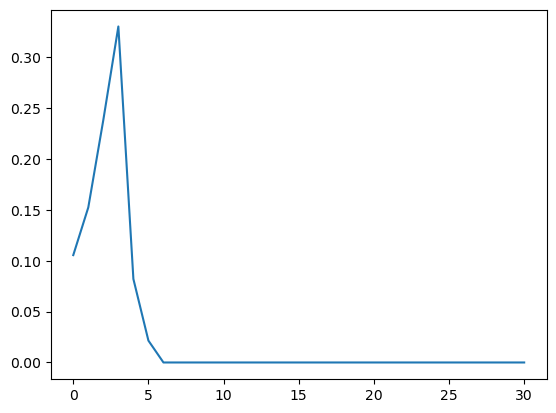

In [19]:
eval_model('awni00/math-polynomials__evaluate/model-comic-feather-3:latest', val_ds, q_text_vectorizer=q_text_vectorizer_, a_text_vectorizer=a_text_vectorizer_)

### Relational Abstractor - Medium

wandb:   5 of 5 files downloaded.  


evaluation on val_ds
20/20 [==============================] - 18s 885ms/step - loss: 26.8416 - teacher_forcing_accuracy: 0.6147
{'loss': 26.841646194458008, 'teacher_forcing_accuracy': 0.6146877408027649}

evaluating full-sequence accuracy on a single batch of size 512
full_seq_acc: 0.0
acc by position

sample of predictions:

Q: Let[UNK]r(v)[UNK]=[UNK]-309*v**2[UNK]-[UNK]2207*v[UNK]-[UNK]308.[UNK]Determine[UNK]r(-7).
A: 0;
P: 4;4;4;;;;;4;4;4;;;;;4;4;;;4;4;;

Q: Let[UNK]d(s)[UNK]=[UNK]4*s**2[UNK]-[UNK]127*s[UNK]-[UNK]2962.[UNK]Determine[UNK]d(47).
A: -95;
P: 1;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;

Q: Let[UNK]f(p)[UNK]=[UNK]79*p**2[UNK]+[UNK]558*p[UNK]-[UNK]137.[UNK]Determine[UNK]f(-7).
A: -172;
P: 0;0;;;;;;;;;;;;;;;;;;;;;;;;;;;;

Q: Let[UNK]n(v)[UNK]=[UNK]968*v[UNK]-[UNK]35729.[UNK]Calculate[UNK]n(37).
A: 87;
P: 7;;;;;;;;;;;;;;;;;;;7;;;;;;;;;;

Q: Let[UNK]y(k)[UNK]=[UNK]3*k**3[UNK]-[UNK]11*k**2[UNK]+[UNK]140*k[UNK]-[UNK]136.[UNK]Calculate[UNK]y(1).
A: -4;
P: ;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;


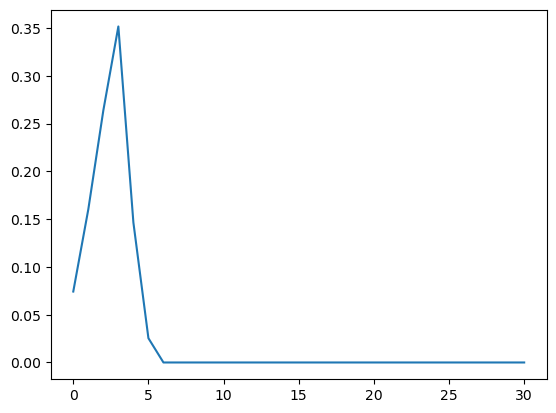

In [20]:
eval_model('awni00/math-polynomials__evaluate/model-major-pond-2:latest', val_ds, q_text_vectorizer=q_text_vectorizer_, a_text_vectorizer=a_text_vectorizer_)

### Relational Abstractor2 - Medium

wandb:   5 of 5 files downloaded.  


evaluation on val_ds
20/20 [==============================] - 16s 788ms/step - loss: 23.5552 - teacher_forcing_accuracy: 0.6339
{'loss': 23.555192947387695, 'teacher_forcing_accuracy': 0.6339327096939087}

evaluating full-sequence accuracy on a single batch of size 512
full_seq_acc: 0.0
acc by position

sample of predictions:

Q: Let[UNK]b(r)[UNK]=[UNK]-r**3[UNK]+[UNK]154*r**2[UNK]-[UNK]2678*r[UNK]-[UNK]275.[UNK]Calculate[UNK]b(134).
A: -7;
P: 39;;;;;;;-;;;;;;;;;;;;;;1;;;;;;

Q: Let[UNK]j(b)[UNK]=[UNK]-2*b**2[UNK]-[UNK]140*b[UNK]+[UNK]4565.[UNK]Determine[UNK]j(-94).
A: 53;
P: 7;7;;;;;;;;;;;;;;;;;;;;;;;;;;;;

Q: Let[UNK]c(r)[UNK]=[UNK]768*r[UNK]+[UNK]209669.[UNK]Give[UNK]c(-273).
A: 5;
P: 5;5;;;;;;;;;;;;;;;;;;;;;;;;;;;;

Q: Let[UNK]w(a)[UNK]=[UNK]-8*a**2[UNK]+[UNK]128*a[UNK]-[UNK]213.[UNK]Calculate[UNK]w(14).
A: 11;
P: 9;7;;;;;;;;;;;;;;;;;;;;;;;;;;;;

Q: Let[UNK]t(m)[UNK]=[UNK]-m**2[UNK]-[UNK]16*m[UNK]-[UNK]38.[UNK]Calculate[UNK]t(-36).
A: -758;
P: 338;;;;;;;;;;;;;;;;;;;;;;;;;;;;


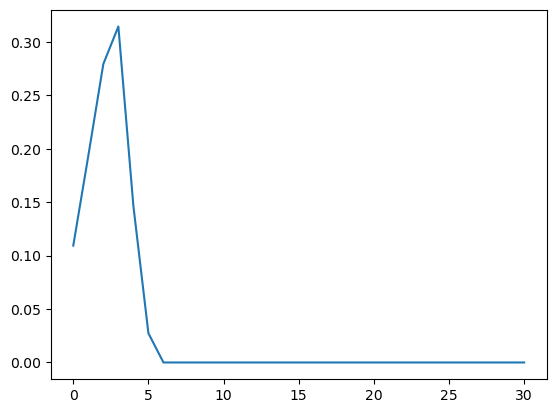

In [21]:
eval_model('awni00/math-polynomials__evaluate/model-cool-donkey-5:latest', val_ds, q_text_vectorizer=q_text_vectorizer_, a_text_vectorizer=a_text_vectorizer_)

## comparison__kth_biggest

In [22]:
# region
# global max lengths of questions and answers
vocab = np.loadtxt('text_vectorizer_vocabs/global_old/vocabulary.txt', dtype=str)

q_text_vectorizer_ = tf.keras.layers.TextVectorization(
    standardize=None,
    split='character',
    output_mode='int',
    output_sequence_length=max_q_length,
    vocabulary=vocab
)

a_text_vectorizer_ = tf.keras.layers.TextVectorization(
    standardize=None,
    split='character',
    output_mode='int',
    output_sequence_length=max_a_length+2,
    vocabulary=vocab
)

# endregion

In [23]:
train_ds, val_ds = load_dataset('comparison__kth_biggest', train_size=-1, batch_size=512,
    q_text_vectorizer=q_text_vectorizer_, a_text_vectorizer=a_text_vectorizer_)

### Transformer - Medium

wandb:   5 of 5 files downloaded.  


evaluation on val_ds
20/20 [==============================] - 8s 383ms/step - loss: 22.9916 - teacher_forcing_accuracy: 0.9777
{'loss': 22.991586685180664, 'teacher_forcing_accuracy': 0.9776961207389832}

evaluating full-sequence accuracy on a single batch of size 512
full_seq_acc: 0.0
acc by position

sample of predictions:

Q: Which[UNK]is[UNK]the[UNK]fourth[UNK]biggest[UNK]value?[UNK][UNK](a)[UNK]10.7[UNK][UNK](b)[UNK]-13[UNK][UNK](c)[UNK]-3[UNK][UNK](d)[UNK]2/17[UNK][UNK](e)[UNK]-0.3
A: c;
P: c;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;

Q: What[UNK]is[UNK]the[UNK]fourth[UNK]biggest[UNK]value[UNK]in[UNK]-3,[UNK]-89,[UNK]5647,[UNK]-1/3?
A: -89;
P: -89;;;;;;;;;86647;;;;;;;;866666

Q: Which[UNK]is[UNK]the[UNK]second[UNK]biggest[UNK]value?[UNK][UNK](a)[UNK]-1/3[UNK][UNK](b)[UNK]-4[UNK][UNK](c)[UNK]1/3[UNK][UNK](d)[UNK]-22532
A: a;
P: c;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;

Q: What[UNK]is[UNK]the[UNK]second[UNK]smallest[UNK]value[UNK]in[UNK]-0.4,[UNK]4,[UNK]-101,[UNK]-1,[UNK]29?
A: -1;
P: -1;1;;;;;;;;1;1;1

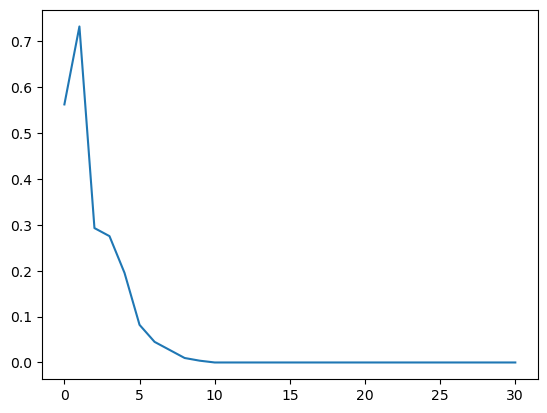

In [24]:
eval_model('awni00/math-comparison__kth_biggest/model-daily-glade-4:v31', val_ds, q_text_vectorizer=q_text_vectorizer_, a_text_vectorizer=a_text_vectorizer_)

### Relational Abstractor - Medium

wandb:   5 of 5 files downloaded.  


evaluation on val_ds
20/20 [==============================] - 18s 883ms/step - loss: 21.6170 - teacher_forcing_accuracy: 0.9948
{'loss': 21.61697006225586, 'teacher_forcing_accuracy': 0.9948359131813049}

evaluating full-sequence accuracy on a single batch of size 512
full_seq_acc: 0.0
acc by position

sample of predictions:

Q: What[UNK]is[UNK]the[UNK]smallest[UNK]value[UNK]in[UNK]-1,[UNK]-12,[UNK]-0.17763?
A: -12;
P: -12;63;;;;;;;;;;;;;;;;;;;;;;;;;

Q: What[UNK]is[UNK]the[UNK]fourth[UNK]smallest[UNK]value[UNK]in[UNK]305,[UNK]2/3,[UNK]9/4,[UNK]-0.58?
A: 305;
P: 305;;;;;;;;;;;;;;;;;;;;;;;;;;;;

Q: What[UNK]is[UNK]the[UNK]sixth[UNK]biggest[UNK]value[UNK]in[UNK]5,[UNK]0.2,[UNK]-3/2,[UNK]-2,[UNK]0,[UNK]0.01,[UNK]-21.76?
A: -2;
P: -2;.76;6;;;;;;;;;;;;;;;;;;;;;;;

Q: Which[UNK]is[UNK]the[UNK]third[UNK]smallest[UNK]value?[UNK][UNK](a)[UNK]98[UNK][UNK](b)[UNK]-5[UNK][UNK](c)[UNK]2/7[UNK][UNK](d)[UNK]0.5[UNK][UNK](e)[UNK]0[UNK][UNK](f)[UNK]676
A: c;
P: c;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;

Q: Which

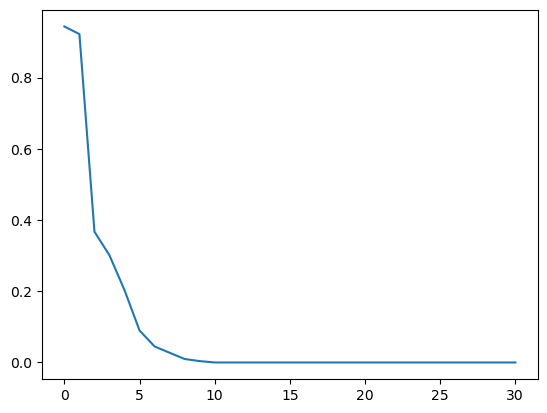

In [25]:
eval_model('awni00/math-comparison__kth_biggest/model-honest-morning-3:latest', val_ds, q_text_vectorizer=q_text_vectorizer_, a_text_vectorizer=a_text_vectorizer_)

## `comparison__sort`

In [26]:
# region
task = 'comparison__sort'
train_ds, val_ds = load_dataset(task, train_size=-1, batch_size=512)
# endregion

### Transformer - Medium

wandb:   5 of 5 files downloaded.  


evaluation on val_ds
20/20 [==============================] - 8s 383ms/step - loss: 0.0027 - teacher_forcing_accuracy: 0.9984
{'loss': 0.002686685649678111, 'teacher_forcing_accuracy': 0.9984191060066223}

evaluating full-sequence accuracy on a single batch of size 512
full_seq_acc: 0.98046875
acc by position

sample of predictions:

Q: Sort 1, 2, -6, -36, 368 in ascending order.
A: -36, -6, 1, 2, 368;
P: -36, -6, 1, 2, 368;

Q: Sort -5, 1159848, 7, -3 in decreasing order.
A: 1159848, 7, -3, -5;
P: 1159848, 7, -3, -5;

Q: Sort 5, -5, 2, -72, -3, 17, -1 in decreasing order.
A: 17, 5, 2, -1, -3, -5, -72;
P: 17, 5, 2, -1, -3, -5, -72;

Q: Put -11, 5, 2, 123, 0, 8, -3 in descending order.
A: 123, 8, 5, 2, 0, -3, -11;
P: 123, 8, 5, 2, 0, -3, -11;

Q: Sort 0, 0.2, -0.04, 25, 4.3, 0.5 in decreasing order.
A: 25, 4.3, 0.5, 0.2, 0, -0.04;
P: 25, 4.3, 0.5, 0.2, 0, -0.04;


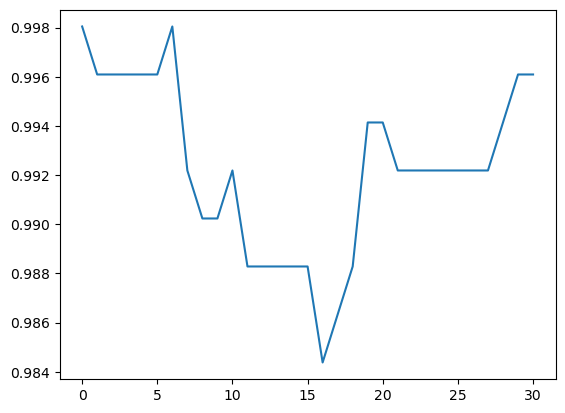

In [27]:
eval_model('awni00/math-comparison__sort/model-peach-bush-6:latest', val_ds)

### Relational Abstractor - Medium

wandb:   5 of 5 files downloaded.  


evaluation on val_ds
20/20 [==============================] - 16s 786ms/step - loss: 0.0027 - teacher_forcing_accuracy: 0.9984
{'loss': 0.0027438742108643055, 'teacher_forcing_accuracy': 0.9984143972396851}

evaluating full-sequence accuracy on a single batch of size 512
full_seq_acc: 0.9765625
acc by position

sample of predictions:

Q: Sort 0, -5, 1, -4, -443, -2, 23 in descending order.
A: 23, 1, 0, -2, -4, -5, -443;
P: 23, 1, 0, -2, -4, -5, -443;

Q: Put 5, -3/14, 1, -2, 0.6, -1/8 in increasing order.
A: -2, -3/14, -1/8, 0.6, 1, 5;
P: -2, -3/14, -1/8, 0.6, 1, 5;

Q: Put -52, 2, -30, -11 in descending order.
A: 2, -11, -30, -52;
P: 2, -11, -30, -52;

Q: Put -7, 2, 3975, -29 in descending order.
A: 3975, 2, -7, -29;
P: 3975, 2, -7, -29;

Q: Put 140, -62, 1/47, 3/7 in ascending order.
A: -62, 1/47, 3/7, 140;
P: -62, 1/47, 3/7, 140;


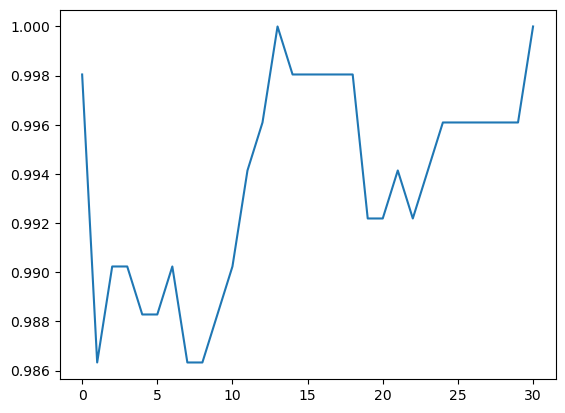

In [28]:
eval_model('awni00/math-comparison__sort/model-summer-armadillo-7:latest', val_ds)

### Relational Abstractor2 - Medium

wandb:   5 of 5 files downloaded.  


evaluation on val_ds
20/20 [==============================] - 18s 875ms/step - loss: 0.0635 - teacher_forcing_accuracy: 0.9655
{'loss': 0.06346913427114487, 'teacher_forcing_accuracy': 0.9654586911201477}

evaluating full-sequence accuracy on a single batch of size 512
full_seq_acc: 0.470703125
acc by position

sample of predictions:

Q: Put 3, 103260, 0, -2 in decreasing order.
A: 103260, 3, 0, -2;
P: 103260, 3, 0, -2;

Q: Sort -4407, 1, -3, -5, 8, 6.
A: -4407, -5, -3, 1, 6, 8;
P: -5, -4407, -3, 1, 6, 8;

Q: Sort 94, -1, 18, -86, -0.2, 2/15, 5 in ascending order.
A: -86, -1, -0.2, 2/15, 5, 18, 94;
P: -86, -1, -0.2, 2/15, 94, 18, 5;

Q: Sort 5, 3/232, -1099/5 in ascending order.
A: -1099/5, 3/232, 5;
P: -1099/5, 3/232, 5;

Q: Put 7.5, 1/2, -4/9, -7/33, 2 in decreasing order.
A: 7.5, 2, 1/2, -7/33, -4/9;
P: 7.5, 2, 1/2, -4/9, -7/33;


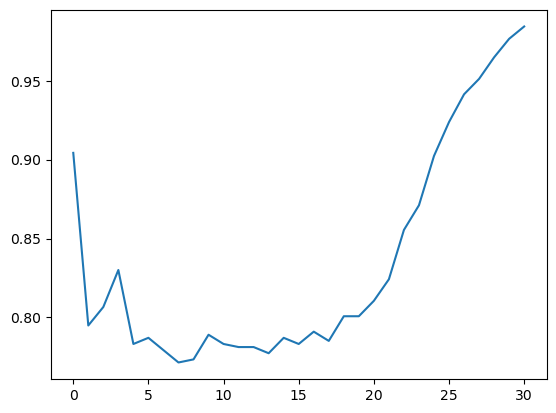

In [29]:
eval_model('awni00/math-comparison__sort/model-silver-eon-5:v0', val_ds)

## `probability__swr_p_level_set`

In [30]:
# region
task = 'probability__swr_p_level_set'
train_ds, val_ds = load_dataset(task, train_size=-1, batch_size=512)
# endregion

### Transformer - Medium

wandb:   5 of 5 files downloaded.  


evaluation on val_ds
20/20 [==============================] - 8s 384ms/step - loss: 15.2650 - teacher_forcing_accuracy: 0.7099
{'loss': 15.264962196350098, 'teacher_forcing_accuracy': 0.7098663449287415}

evaluating full-sequence accuracy on a single batch of size 512
full_seq_acc: 0.0
acc by position

sample of predictions:

Q: Three letters picked without replacement from {t: 1, v: 2, g: 5, p: 1, e: 4, d: 1}. Give prob of picking 1 t and 2 e.
A: 3/182;
P: 1/91;;;;;;;;;;;;;;;;;;;;;;;;;;;

Q: What is prob of picking 1 c and 1 r when two letters picked without replacement from {r: 1, m: 1, e: 2, d: 2, c: 2, t: 6}?
A: 2/91;
P: 2/39;;;;;;;;;;;;;;;;;;;;;;;;;;;

Q: What is prob of picking 2 y, 1 r, and 1 s when four letters picked without replacement from {y: 5, s: 1, r: 2, g: 5}?
A: 4/143;
P: 20/99;;;;;;;;;;;;;;;;;;;;;;;;;;

Q: Three letters picked without replacement from gjjjjqsxjjsxjjjq. Give prob of picking 1 g, 1 s, and 1 x.
A: 1/140;
P: 1/28;;;;;;;;;;;;;;;;;;;;;;;;;;;

Q: What is pro

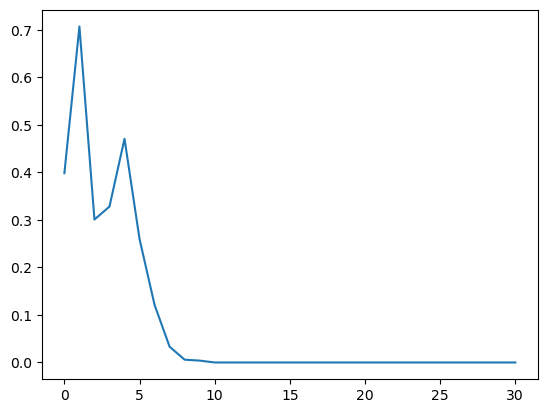

In [31]:
eval_model('awni00/math-probability__swr_p_level_set/model-stellar-butterfly-4:latest', val_ds)

### Relational Abstractor - Medium

wandb:   5 of 5 files downloaded.  


evaluation on val_ds
20/20 [==============================] - 17s 796ms/step - loss: 12.0555 - teacher_forcing_accuracy: 0.7173
{'loss': 12.055521011352539, 'teacher_forcing_accuracy': 0.7173019051551819}

evaluating full-sequence accuracy on a single batch of size 512
full_seq_acc: 0.0
acc by position

sample of predictions:

Q: What is prob of picking 3 u when three letters picked without replacement from hhhuhhhuuuhh?
A: 1/55;
P: 1/220;;;;;;;;;;;;;;;;;;;;;;;;;;

Q: Two letters picked without replacement from {k: 3, t: 5, x: 7}. What is prob of picking 2 t?
A: 2/21;
P: 7/40;;;;;;;;;;;;;;;;;;;;;;;;;;;

Q: Three letters picked without replacement from {c: 7, v: 2, w: 3, g: 2}. Give prob of picking 2 w and 1 c.
A: 3/52;
P: 1/52;;;;;;;;;;;;;;;;;;;;;;;;;;;

Q: What is prob of picking 2 x when two letters picked without replacement from {u: 1, s: 5, i: 3, n: 2, w: 4, x: 2}?
A: 1/136;
P: 1/136;;;;;;;;;;;;;;;;;;;;;;;;;;

Q: Four letters picked without replacement from zhzhzzzhzzhzzzhhzzzh. G

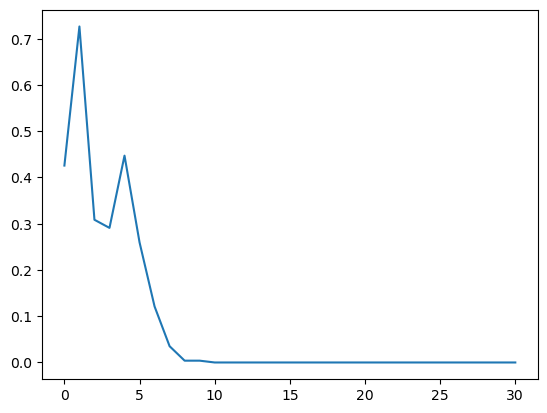

In [32]:
eval_model('awni00/math-probability__swr_p_level_set/model-dandy-blaze-3:latest', val_ds)

## `algebra__polynomial_roots`

In [33]:
# region
# global max lengths of questions and answers
max_q_length_, max_a_length_ = 138, 30
q_text_vectorizer_ = tf.keras.layers.TextVectorization(
    standardize=None,
    split='character',
    output_mode='int',
    output_sequence_length=max_q_length_,
    # vocabulary=vocab
)

a_text_vectorizer_ = tf.keras.layers.TextVectorization(
    standardize=None,
    split='character',
    output_mode='int',
    output_sequence_length=max_a_length_+2,
    # vocabulary=vocab
)

q_text_vectorizer_.load_assets('text_vectorizer_vocabs/algebra__polynomial_roots')
a_text_vectorizer_.load_assets('text_vectorizer_vocabs/algebra__polynomial_roots')
# endregion

In [34]:
train_ds, val_ds = load_dataset('algebra__polynomial_roots', train_size=-1, batch_size=512,
    q_text_vectorizer=q_text_vectorizer_, a_text_vectorizer=a_text_vectorizer_,
    max_q_length=max_q_length_, max_a_length=max_a_length_)

### Transformer - Medium

wandb:   5 of 5 files downloaded.  


evaluation on val_ds
20/20 [==============================] - 7s 336ms/step - loss: 0.3287 - teacher_forcing_accuracy: 0.7956
{'loss': 0.328652948141098, 'teacher_forcing_accuracy': 0.7955571413040161}

evaluating full-sequence accuracy on a single batch of size 512
full_seq_acc: 0.0
acc by position

sample of predictions:

Q: Factor r**3 - 305633*r**2 + 611263*r - 305631.
A: (r - 305631)*(r - 1)**2;
P: 3- 305631)*(r - 1)**2;

Q: Suppose -410*u**3 + 10863*u**2 - 10402*u - 51 = 0. What is u?
A: -1/205, 1, 51/2;
P:  1)1)3/140, 1, 21;

Q: What is s in 2*s**4/11 - 46*s**3/11 - 678*s**2/11 + 414*s/11 + 540 = 0?
A: -10, -3, 3, 33;
P:  2)11;

Q: Factor -k**3/2 + 81*k**2/2 + 25343*k - 76380.
A: -(k - 268)*(k - 3)*(k + 190)/2;
P:  2(k - 115)*(k - 2)*(k + 124)/2

Q: Solve 1089*q**3/2 + 47751*q**2 + 2648737*q/2 + 11195912 = 0 for q.
A: -1183/33, -16;
P:  - 4)*3/2089;


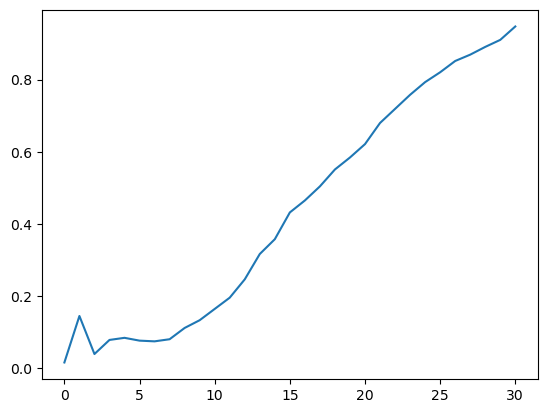

In [35]:
eval_model('awni00/math_algebra__polynomial_roots /model-elated-darkness-3:v35', val_ds, q_text_vectorizer=q_text_vectorizer_, a_text_vectorizer=a_text_vectorizer_)

### Relational Abstractor - Medium

wandb:   5 of 5 files downloaded.  


evaluation on val_ds
20/20 [==============================] - 17s 795ms/step - loss: 0.2167 - teacher_forcing_accuracy: 0.8585
{'loss': 0.21671362221240997, 'teacher_forcing_accuracy': 0.8585386872291565}

evaluating full-sequence accuracy on a single batch of size 512
full_seq_acc: 0.0078125
acc by position

sample of predictions:

Q: Find i, given that 4*i**5 - 326164*i**4 + 6652684152*i**3 - 152853260632*i**2 + 285749773444*i - 139548870804 = 0.
A: 1, 21, 40759;
P: 1-1, 1, 3, 40759;

Q: Factor -1222*r**2 - 34254*r - 1064.
A: -2*(r + 28)*(611*r + 19);
P: -3+++++++++++++++++++++++++++++

Q: Let 4*z**4 - 228*z**3 - 8308*z**2 - 63516*z - 55440 = 0. Calculate z.
A: -15, -11, -1, 84;
P: ( - 60)*-7, -1, 18;

Q: Factor f**2 + 7010364*f + 12286300853124.
A: (f + 3505182)**2;
P: -3555182)**2;

Q: Suppose 10*v**3/9 - 257276*v**2/9 - 360202*v/9 - 102916/9 = 0. Calculate v.
A: -1, -2/5, 25729;
P: ( - 25728;


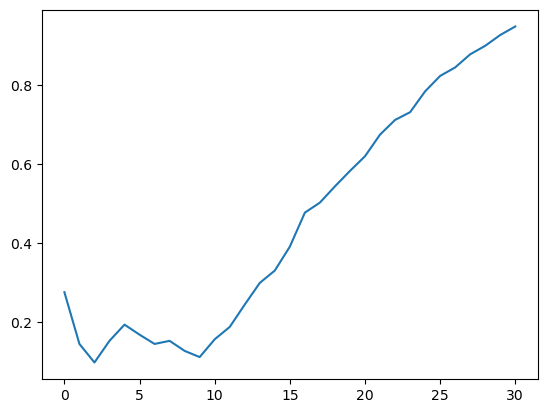

In [36]:
eval_model('awni00/math_algebra__polynomial_roots /model-rural-sea-1:latest', val_ds, q_text_vectorizer=q_text_vectorizer_, a_text_vectorizer=a_text_vectorizer_)

## numbers__list_prime_factors

In [37]:
# region
# global max lengths of questions and answers
max_q_length, max_a_length = 160, 30

vocab = np.loadtxt('text_vectorizer_vocabs/global_old/vocabulary.txt', dtype=str)

q_text_vectorizer_ = tf.keras.layers.TextVectorization(
    standardize=None,
    split='character',
    output_mode='int',
    output_sequence_length=max_q_length,
    vocabulary=vocab
)

a_text_vectorizer_ = tf.keras.layers.TextVectorization(
    standardize=None,
    split='character',
    output_mode='int',
    output_sequence_length=max_a_length+2,
    vocabulary=vocab
)

# endregion

In [38]:
train_ds, val_ds = load_dataset('numbers__list_prime_factors', train_size=-1, batch_size=512,
    q_text_vectorizer=q_text_vectorizer_, a_text_vectorizer=a_text_vectorizer_)

### Transformer - Medium

wandb:   5 of 5 files downloaded.  


evaluation on val_ds
20/20 [==============================] - 8s 378ms/step - loss: 0.4521 - teacher_forcing_accuracy: 0.6578
{'loss': 0.45209023356437683, 'teacher_forcing_accuracy': 0.6577602028846741}

evaluating full-sequence accuracy on a single batch of size 512
full_seq_acc: 0.0
acc by position

sample of predictions:

Q: What[UNK]are[UNK]the[UNK]prime[UNK]factors[UNK]of[UNK]30935275?
A: 5,[UNK]7,[UNK]43,[UNK]4111;
P: ;

Q: List[UNK]the[UNK]prime[UNK]factors[UNK]of[UNK]96021341.
A: 13,[UNK]7386257;
P: ;

Q: What[UNK]are[UNK]the[UNK]prime[UNK]factors[UNK]of[UNK]86031807?
A: 3,[UNK]1511,[UNK]18979;
P: ;

Q: List[UNK]the[UNK]prime[UNK]factors[UNK]of[UNK]2109079.
A: 7,[UNK]503,[UNK]599;
P: ;

Q: List[UNK]the[UNK]prime[UNK]factors[UNK]of[UNK]46406404.
A: 2,[UNK]11,[UNK]95881;
P: ;


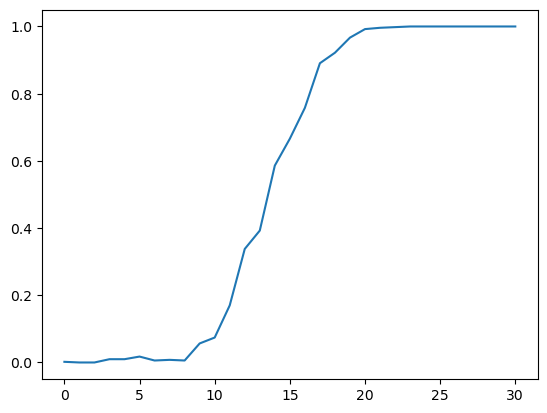

In [39]:
eval_model('awni00/math-numbers__list_prime_factors/model-woven-puddle-1:latest', val_ds, q_text_vectorizer=q_text_vectorizer_, a_text_vectorizer=a_text_vectorizer_)

### Relational Abstractor - Medium

wandb:   5 of 5 files downloaded.  


evaluation on val_ds
20/20 [==============================] - 18s 889ms/step - loss: 0.3464 - teacher_forcing_accuracy: 0.7314
{'loss': 0.3463696241378784, 'teacher_forcing_accuracy': 0.7313769459724426}

evaluating full-sequence accuracy on a single batch of size 512
full_seq_acc: 0.0
acc by position

sample of predictions:

Q: What[UNK]are[UNK]the[UNK]prime[UNK]factors[UNK]of[UNK]93087835?
A: 5,[UNK]17,[UNK]41,[UNK]26711;
P: ;

Q: List[UNK]the[UNK]prime[UNK]factors[UNK]of[UNK]80640449.
A: 80640449;
P: ;

Q: List[UNK]the[UNK]prime[UNK]factors[UNK]of[UNK]48170255.
A: 5,[UNK]7,[UNK]59,[UNK]23327;
P: ;

Q: What[UNK]are[UNK]the[UNK]prime[UNK]factors[UNK]of[UNK]871073?
A: 7,[UNK]29,[UNK]613;
P: ;

Q: List[UNK]the[UNK]prime[UNK]factors[UNK]of[UNK]40922035.
A: 5,[UNK]7,[UNK]11,[UNK]106291;
P: ;


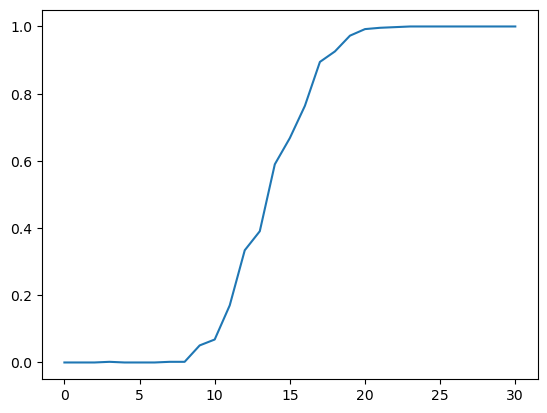

In [40]:
eval_model('awni00/math-numbers__list_prime_factors/model-upbeat-grass-3:latest', val_ds, q_text_vectorizer=q_text_vectorizer_, a_text_vectorizer=a_text_vectorizer_)